# Data analysis tutorial:
## Search for a Gaussian signal peak in an invariant mass spectrum that contains background.

### 1. Definition of the expected signal and background distributions.

In [1]:
# Native Python modules
import os, sys, csv, string, math

# Scipy/Numpy modules
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import Markdown
plt.style.use('bmh')
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'legend.fontsize': 15})
plt.rcParams['font.family'] = "STIXGeneral"
plt.rcParams.update({'figure.figsize': [8, 6]})



# IPython magic: automatic reload of modified modules if any
%load_ext autoreload
%autoreload 2

We are going to define the probability density distributions. In this case a normal (gaussian) and exponential for background. However they will be truncated, ie, not defined between $-\infty, +\infty$ but between two values $\alpha, \beta$. 
The general formulation of a truncated distribution $f(x| \alpha < x < \beta)$ that comes from a distribution $f(x)$ if given by the following expresion:



$$f(x| \alpha < x < \beta) = \frac{f(x)}{F(\beta)-F(\alpha)}$$



where $F(x)$ is the cummulative distribution of the density distribution $f(x)$. For an exponential, this formula can be calculated easily as there is an analytical solution. For the case of the normal distrubution, however, the cumulative is based on the error function.  


#### Definition of the signal and background distributions (normalized to 1), and of the corresponding `SciPy` random variables.
We will use the `scipy` class [`rv_continous`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html) which is a base class to construct specific distribution classes and instances for continuous random variables. You need to create a new class and  re-define at least the `_pdf` or the `_cdf` method.



In [2]:
from scipy.stats import rv_continuous
class truncexpon_gen(rv_continuous):
    def __init__(self, beta, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.beta = beta
        self.norm = -np.exp(-self.b/self.beta) + np.exp(-self.a/self.beta)
    # "Truncated Exponential Distribution"
    def _pdf(self, x):
        return 1.0/self.beta * np.exp(-x/self.beta)/self.norm


class truncgauss_gen(rv_continuous):
    def __init__(self, mu, sigma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mu = mu
        self.sigma = sigma
        self.norm = stats.norm.cdf((self.b-self.mu)/self.sigma) - stats.norm.cdf((self.a-self.mu)/self.sigma)
    def _pdf(self, x):
        # "Truncated Normal Distribution"
        return np.exp(-0.5*((x - self.mu)/self.sigma)**2)/(self.sigma * np.sqrt(2 * np.pi))/self.norm
        
class trunclinear_gen(rv_continuous):
    def __init__(self, constant, slope, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.constant = constant
        self.slope = slope
        self.norm = self.constant * (self.b - self.a) + 0.5 * self.slope * (self.b**2 - self.a**2)
        # "truncated linear distribution"
    def _pdf(self, x):    
        return (self.constant + self.slope * x)/self.norm

`SciPy` random variables; we will need those in order to simulate pseudo-experiments by the MonteCarlo method.

In [3]:
# We assume we are measuring a variable x, distributed between xmin = 110, and xmax  = 140

xmin = 100
xmax = 160
mode = 0 # one for pdf, 1 for ppf 
#Signal generator
signal_generator = truncgauss_gen(125, 2, mode, xmin, xmax)
#Exponential background generator
expo_generator = truncexpon_gen(15, mode, xmin, xmax)
#Lineal background generator
linear_generator = trunclinear_gen(40, -0.2, mode, xmin, xmax)


Display of histograms corresponding to signal and background distributions.

(0.0, 0.25)

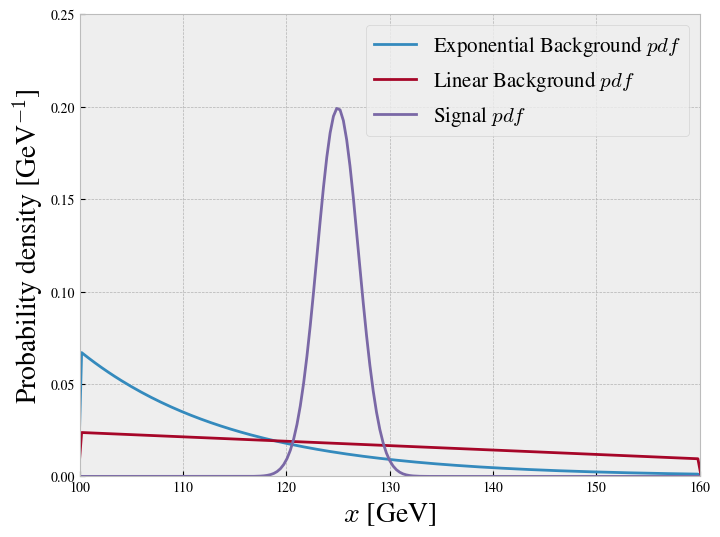

In [4]:
bins_edges = np.linspace(0, xmax, 500)
fig, ax = plt.subplots()
bin_width = np.diff(bins_edges)[0]
bins_centers = bins_edges + bin_width/2
# We calculate the value of the pdfs at the center of bins
ax.plot(bins_centers, expo_generator.pdf(bins_centers), label="Exponential Background $pdf$")
ax.plot(bins_centers, linear_generator.pdf(bins_centers), label="Linear Background $pdf$")
ax.plot(bins_centers, signal_generator.pdf(bins_centers), label = "Signal $pdf$")
ax.legend()
ax.set_xlabel("$x$ [GeV]")
ax.set_ylabel(r"Probability density [GeV$^{-1}$]")
ax.set_xlim(xmin,xmax)
ax.set_ylim(0, 0.25)

Display of histogram corresponding to the expected data. Let's assume some _mean_ expected numbers of events comming for each of these distributions. For example:
* $\mu_{exp} = 607.2$
* $\mu_{linear} = 0$
* $\mu_{signal} = 60.9$

Note that these are mean values, ie, the poisson mean of a random process

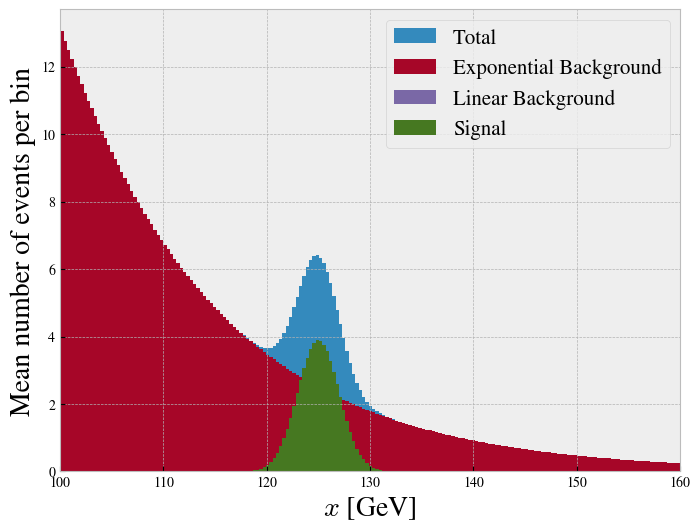

In [5]:
#Now let's assume some number of events for each process
muexpo = 607.2
mulinear = 0
musignal = 60.9

fig, ax1 = plt.subplots()

# Let's put in a container the expected valus of the parameters, n_total, r
from argparse import Namespace
mu = Namespace(ntotal = muexpo + mulinear + musignal, nlinear = mulinear, nexpo = muexpo, r = musignal/(muexpo + mulinear + musignal))

#The following is the extected total per bin
mu_total = mu.nexpo * expo_generator.pdf(bins_centers) + mu.nlinear * linear_generator.pdf(bins_centers) + mu.r * mu.ntotal * signal_generator.pdf(bins_centers)

ax1.bar(bins_centers, bin_width * mu_total, width = bin_width, label = "Total")
ax1.bar(bins_centers, bin_width * mu.nexpo * expo_generator.pdf(bins_centers), width = bin_width, label="Exponential Background")
ax1.bar(bins_centers, bin_width * mu.nlinear * linear_generator.pdf(bins_centers), width = bin_width, label="Linear Background")
ax1.bar(bins_centers, bin_width * mu.r * mu.ntotal * signal_generator.pdf(bins_centers), width = bin_width, label = "Signal")
ax1.legend()
ax1.set_xlabel("$x$ [GeV]")
ax1.set_ylabel("Mean number of events per bin")
ax1.set_xlim(xmin,xmax)
plt.show()

### 2. Pseudo-experiment drawn at random from the expected spectrum.
Now based on these _mean_ expected numbers we are going to create a psuedo-experiment

In [6]:
#unbinned pseudo-data
#the seed of the random number generator is set to a known value 
#such that our analysis code can be tested repeatedly on the same pseudo-data

np.random.seed(90776696)

n_background = np.random.poisson(mu.nexpo)
sample_a = expo_generator.rvs(size = n_background)
n_signal = np.random.poisson(mu.r * mu.ntotal)
sample_b = signal_generator.rvs(size = n_signal)
# Let's put in another container the *true* values of ntotal, r
true = Namespace(ntotal = n_background + n_signal, r = n_signal/(n_background + n_signal))


In [7]:
#Since we are using truncated distribution, there should not be any event generated beyond the limits xmax or xmin
print (len(sample_b[sample_b > xmax]))

0


number of simulated events: 726
events per bin: [38. 40. 52. 55. 29. 43. 28. 35. 29. 17. 32. 30. 24. 16. 13. 15. 13. 12.
 22. 21. 31. 11. 21.  4.  5.  7.  6.  8.  7.  7.  6.  3.  3.  7.  6.  2.
  4.  4.  4.  1.  1.  3.  0.  1.  3.  3.  0.  4.  0.]


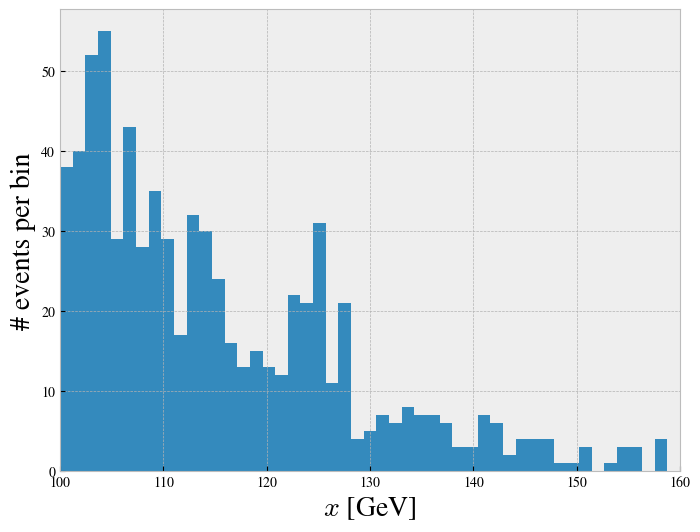

In [8]:
data = np.concatenate([sample_b, sample_a])
#
print(f"number of simulated events: {len(data)}")

#mise en histogramme des masses invariantes tirées aléatoirement
fig, ax3 = plt.subplots()
c, bins, p = ax3.hist(data, bins=np.linspace(xmin, xmax, 50))
print(f"events per bin: {c}")
ax3.set_xlim(xmin, xmax)
ax3.set_xlabel("$x$ [GeV]")
ax3.set_ylabel("# events per bin")
plt.show()

### 3. Unbinned maximum-likelihood fit of the total number of events and of the signal fraction.

#### First thing to do:
Write down on paper (or on tablet) the expression of the likelihood of a pseudo-experiment. As parameters to fit, we will choose the total number of events $n_{total}$ and the signal fraction $r = n_{signal}/n_{total}$. We could have chosen the numbers of signal and of background events instead (you could try this as an exercise).

#### Unbinned $-\ln(\mathcal{L})$ in the $S+B$ hypothesis

In [10]:
def UnbinnedNLL(data: np.array, s: np.array, b: np.array, args: tuple) -> float:
    
    values = np.log((1-args[1])*b(data) + args[1]*s(data))
    return - (np.sum(values) - args[0] + len(data) * np.log(args[0]))



Now let's use `iminuit` to minimize the likelihood function defined above

In [11]:
# Let's use imuit iminuit and we are going to handle different versions
import iminuit 
print(f"Minuit version {iminuit.__version__}")

from packaging import version
m_version = version.parse(iminuit.__version__) < version.parse("2.0.0")


Minuit version 2.30.1


In [12]:
# ntot and r are fitted by minimizing -2.ln(L)

#expected and initial values of ntot and r

print(f'Expected mean ntotal: {mu.ntotal}')
print(f'True value of ntotal in the pseudo-experiment: {true.ntotal}')
print(f'Expected mean r: {mu.r:.3f}')
print(f'True value of r in the pseudo-experiment: {true.r:.3f}')


Expected mean ntotal: 668.1
True value of ntotal in the pseudo-experiment: 726
Expected mean r: 0.091
True value of r in the pseudo-experiment: 0.081


In [14]:
print (iminuit.Minuit.LIKELIHOOD)

0.5


In [ ]:
# Let's create a parser to the likelihood function called funcU which will take only the arguments, ie the free parameters 
def funcU(args: tuple) -> float:
    return UnbinnedNLL(data, signal_generator.pdf, expo_generator.pdf, tuple(args))

#Depending on the iminuit version we have different ways to call the function
if not m_version:
    m = iminuit.Minuit(funcU, (mu.ntotal, mu.r), name=("$n_{total}$", "$r$"))
    m.errordef = iminuit.Minuit.LIKELIHOOD #This tells iminuit that the cost function is a negative log-likelihood    
else:
    m = iminuit.Minuit.from_array_func(funcU, (mu.ntotal, mu.r), errordef = iminuit.Minuit.LIKELIHOOD)



#### Minimization
Now let's minimize the likelihood using the method `iminuit.migrad`

In [15]:
# We minimize
m.migrad()

/usr/local/lib/python3.13/site-packages/iminuit/_repr_text.py:245: OptionalDependencyWarning: rendering simple LaTeX requires optional package 'unicodeitplus'. Install 'unicodeitplus' manually to enable this functionality.
  with optional_module_for("rendering simple LaTeX"):


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1381                      │              Nfcn = 34               │
│ EDM = 1.38e-07 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name        │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $n_{total}$ │    726    │    27     │            │            │         │         │       │
│ 1 │ $r$         │   0.074   │   0.015   │            │            │         │         │       │
└───┴─────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────────┬─────────────────────────┐
│             │ $n_{total}$         $r$ │
├─────────────┼─────────────────────────┤
│ $n_{total}$ │         726          -0 │
│         $r$ │          -0     0.00023 │
└─────────────┴─────────────────────────┘

The output already tells you the results of the fit, but the method `m.values` returns the values in case they are needed. For example, let's plot together the model and the data to verify they agree


In [16]:
#Let's put the fitted results in a container
fit = Namespace(ntotal = m.values[0], r = m.values[1])

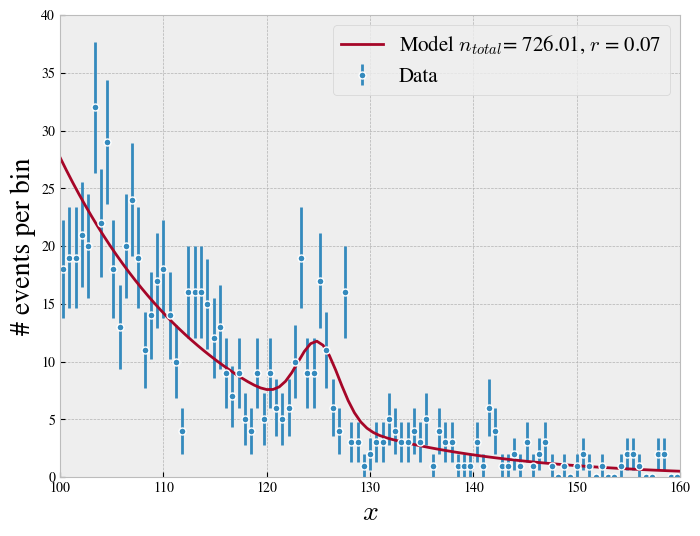

In [17]:
fig, ax3 = plt.subplots()
nbins = np.linspace(xmin, xmax, 100)

#Let's calcualte the bind width, assuming all bins are equal
binwidth = np.diff(nbins)[0]
## Let's define our model:

def model(x, par):
    return par[0]*(par[1] * signal_generator.pdf(x) + (1 - par[1]) * expo_generator.pdf(x))

hist, bin_edges = np.histogram(data, bins = nbins)
bincenters = bin_edges[:-1] + np.diff(bin_edges)/2
ax3.errorbar(bincenters, hist, np.sqrt(hist), label="Data",fmt='o', ms = 5, markeredgecolor="white")

#To have a proper nomalization we need to weight the model by the binwidth
ax3.plot(nbins, binwidth * model(nbins, (fit.ntotal, fit.r)), lw=2, label= r"Model $n_{total}$" + f"= {fit.ntotal:.2f}, $r$ = {fit.r:.2f}")
ax3.set_xlim(xmin, xmax)
ax3.set_ylim(0, 40)
ax3.set_xlabel("$x$")
ax3.set_ylabel("# events per bin")
ax3.legend()
plt.show()

### Estimating uncertainties
Now let's try to estimate the errors on both $r$ and $n_{total}$ for that let's use the standard approach of using the likelihood function around the minimum and evaluate the interval when the negative log likelihood increases 0.5

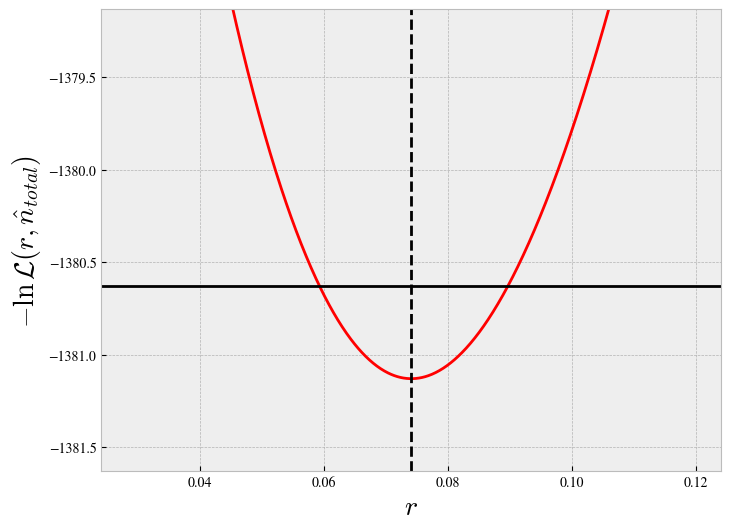

In [18]:
#-ln(L) as a function of r, ntot being fixed to the best-fit value
#choice of the interval in r, we pick a window of 0.05 between the best fit value of r
rinf = fit.r - 0.05
rsup = fit.r + 0.05

fig, ax5 = plt.subplots()
x_grid = np.linspace(rinf,rsup,1000)
#We calculate the likelihood for each value of r, with ntotal fixed to the global best estimate.
y =  [UnbinnedNLL(data, signal_generator.pdf, expo_generator.pdf, (fit.ntotal, x)) for x in x_grid]
plt.plot(x_grid, y , 'r')

#horizontal line 0.5 unit higher than min(-ln(L))
level = np.min(y) + 0.5
ax5.axhline(y = level, lw=2, color ="black")
ax5.set_xlim(rinf, rsup)
ax5.set_xlabel("$r$")
ax5.set_ylabel(r"$-\ln\mathcal{L}(r, \hat{n}_{total})$")
ax5.set_xlim(rinf, rsup)
ax5.set_ylim(m.fval - 0.5, m.fval  + 2)
ax5.axvline(x = fit.r, color="black", linestyle="dashed")
plt.show()

Now do the same for $n_{total}$
...

In practice `iminuit` can do that too, and it can estimate the errors from the second derivatives of $-\ln(L)$, ie using the Hessian matrix. For that we can simple call the method `m.hesse()`

In [20]:
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1381                      │              Nfcn = 54               │
│ EDM = 1.37e-07 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name        │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $n_{total}$ │    726    │    27     │            │            │         │         │       │
│ 1 │ $r$         │   0.074   │   0.015   │            │            │         │         │       │
└───┴─────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────────┬─────────────────────────┐
│             │ $n_{total}$         $r$ │
├─────────────┼─────────────────────────┤
│ $n_{total}$ │         726           0 │
│         $r$ │           0     0.00023 │
└─────────────┴─────────────────────────┘

And we can plot it

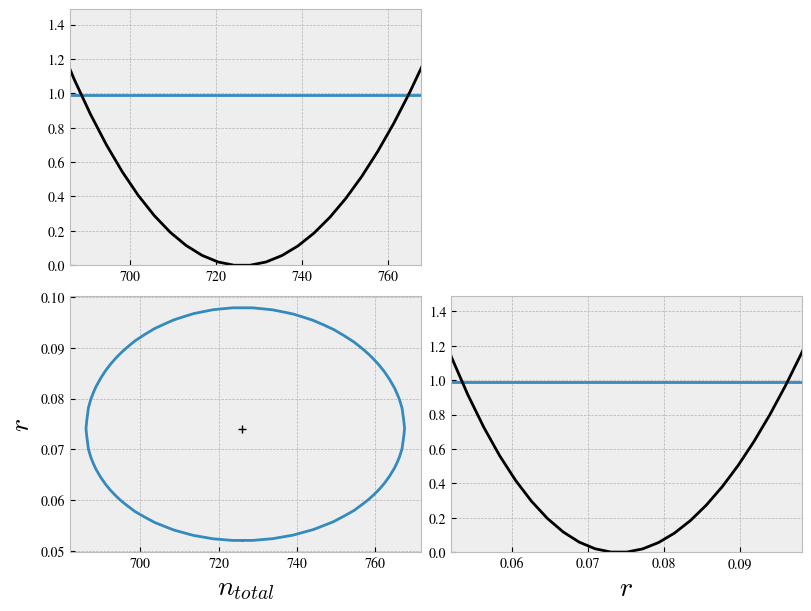

In [21]:
if not m_version:
    m.draw_mnmatrix()
    plt.plot() # Not needed, only to remove the verbatim output


We can draw the likelihood profile, for example along the $r$ variable or $n_{total}$

(array([0.04374397, 0.04583738, 0.04793079, 0.05002421, 0.05211762,
        0.05421103, 0.05630444, 0.05839785, 0.06049126, 0.06258468,
        0.06467809, 0.0667715 , 0.06886491, 0.07095832, 0.07305173,
        0.07514515, 0.07723856, 0.07933197, 0.08142538, 0.08351879,
        0.0856122 , 0.08770561, 0.08979903, 0.09189244, 0.09398585,
        0.09607926, 0.09817267, 0.10026608, 0.1023595 , 0.10445291]),
 array([2.23585778e+00, 1.92132408e+00, 1.63312905e+00, 1.37055961e+00,
        1.13293693e+00, 9.19614313e-01, 7.29975145e-01, 5.63431106e-01,
        4.19420444e-01, 2.97406419e-01, 1.96875842e-01, 1.17337732e-01,
        5.83220642e-02, 1.93786102e-02, 7.58567876e-05, 0.00000000e+00,
        1.87540073e-02, 5.59567425e-02, 1.11242148e-01, 1.84258481e-01,
        2.74667596e-01, 3.82144278e-01, 5.06375611e-01, 6.47060390e-01,
        8.03908565e-01, 9.76640723e-01, 1.16498760e+00, 1.36868960e+00,
        1.58749641e+00, 1.82116652e+00]))

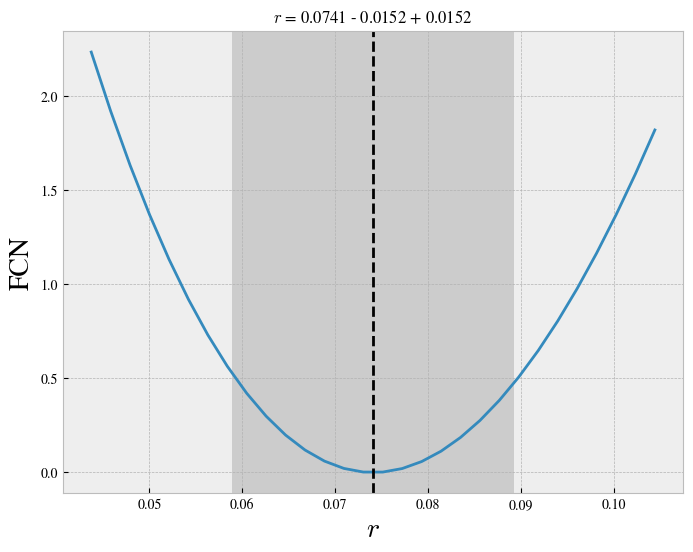

In [25]:
m.draw_mnprofile("$r$")

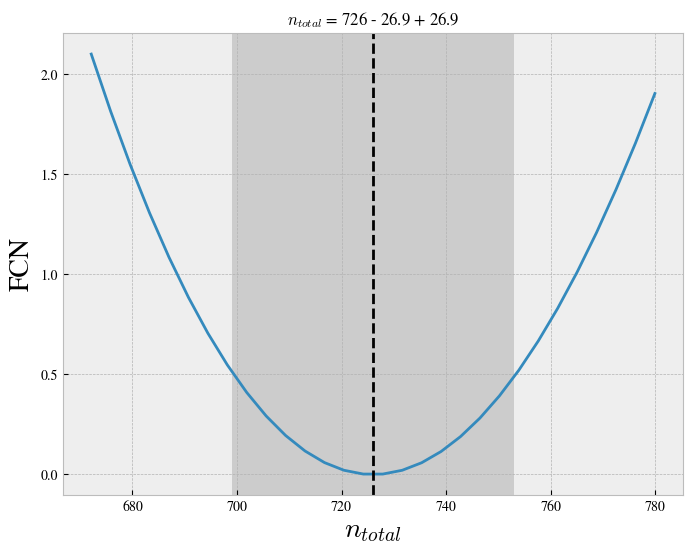

In [26]:

m.draw_mnprofile("$n_{total}$");

Now let's see what is the impact of these errors on our model. For that we are going to create pairs of $n_{total}$ and $r$ from a 2D gaussian distribution with a covariance matrix given by the hessian matrix.

In [35]:
rng = np.random.default_rng(1)
### we generate 1000 variations of the fitted parameters according to their values

if not m_version:
    par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)
else:
    par_b = rng.multivariate_normal(m.np_values(), m.np_matrix(), size = 1000)
    

In [36]:
np.array(m.values)

array([7.26008079e+02, 7.40984392e-02])

In [37]:
# For example this is the first pair
print (par_b[0])

[7.35319741e+02 8.65683300e-02]


For every pair now we can build a model as before, then we take the dispersion of the different models to calculate an error. 

Text(0, 0.5, '# events per bin')

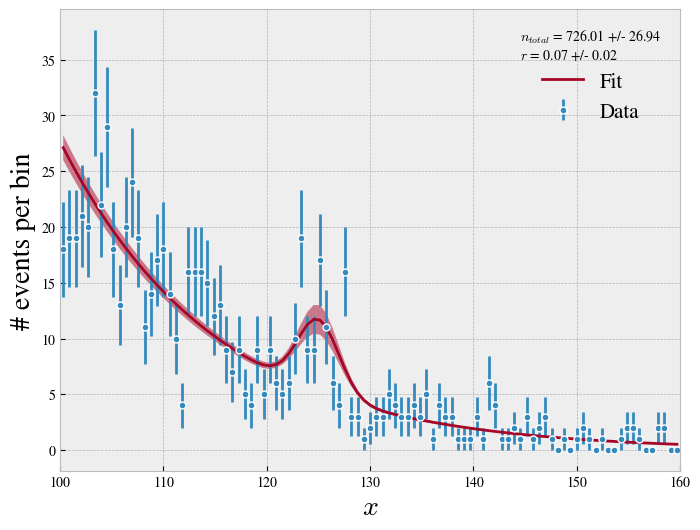

In [39]:
hist, bin_edges = np.histogram(data, bins = nbins)
binwidth = np.diff(bin_edges)[0]
bincenters = bin_edges[:-1] + binwidth/2
## For every pair of parameters, we calculate the model
y_b = [model(bincenters, p) for p in par_b]

## We take as error from bootstraping the standard deviation off all series of y_b times the bin width
yerr_boot =  binwidth * np.std(y_b, axis=0)

fig, ax4 = plt.subplots()

ax4.errorbar(bincenters, hist, np.sqrt(hist), label="Data",fmt='o', ms = 5, markeredgecolor="white")

y =  binwidth * model(bincenters, m.values)
ax4.plot(bincenters, y, lw=2, color="C1", label="Fit") #The model
ax4.fill_between(bincenters, y - yerr_boot, y + yerr_boot, facecolor="C1", alpha=0.5) #The errors
ax4.set_xlim(xmin, xmax)
ax4.legend(frameon=False,
           title=f"$n_{{total}}$ = {m.values[0]:.2f} +/- {m.errors[0]:.2f}\n"
                 f"$r$ = {m.values[1]:.2f} +/- {m.errors[1]:.2f}")
ax4.set_xlabel("$x$")
ax4.set_ylabel("# events per bin")

#These lines will plot each variation of the model
#for i, p in enumerate(par_b):
#      ax4.plot(nbins, np.diff(nbins)[0]*y_b[i])


This give us a graphical interpretation of the variation of our model compared to the data. 

#### Estimation of the uncertainty on $r$ using MonteCarlo pseudo-experiments
We can also use MonteCarlo methods to estimate the errors of the fitted paramers. For example we consider the case where we don't know the true values of $n_{total}$ and $r$, and must therefore draw pseudo-experiments from the only parameter estimations that we have, i.e. the fitted values.

In [41]:


#Let's generate nexp pseudo experiments using the fitted values
nb_fitted = (1 - fit.r) * fit.ntotal # (1-r) * ntotal
ns_fitted = fit.ntotal * fit.r # r * ntotal

#The following function calculates the residuals for r, and ntotal and their variance for ntrials number of pseudo-experiments generted with fit.r and fit.ntotal
def compute(ntrials): 
    r = []
    ntotal = []
    for i in range(ntrials):
        nB = np.random.poisson(nb_fitted)
        nS = np.random.poisson(ns_fitted)

        sample_b = expo_generator.rvs(size = nB)
        sample_s = signal_generator.rvs(size = nS)

        data_trial = np.concatenate([sample_b,sample_s])
        print (f"Sample generated {i+1}/{ntrials}")
        def funcU(args: tuple) -> float:
            return UnbinnedNLL(data_trial, signal_generator.pdf, expo_generator.pdf, tuple(args))


        #Depending on the iminuit version we have different ways to call the function
        if not m_version:
            m = iminuit.Minuit(funcU, (mu.ntotal, mu.r), name=("$n_{total}$", "$r$"))
            m.errordef = iminuit.Minuit.LIKELIHOOD
        else:
            m = iminuit.Minuit.from_array_func(funcU, (mu.ntotal, mu.r), name=("$n_{total}$", "$r$"), errordef = iminuit.Minuit.LIKELIHOOD)
        print ("Minimizing")
        m.migrad()
        r.append(m.values[1])
        ntotal.append(m.values[0])
    
    r = np.array(r)
    ntotal = np.array(ntotal)
    return  np.mean(r - fit.r), np.sqrt((r-fit.r).var()), np.mean(ntotal - fit.ntotal), np.sqrt((ntotal - fit.ntotal).var())

In [42]:
#Let's try it for 5 pseudo experiements
trials = compute(5)
print (f"bias-r = {trials[0]} variance-r =  {trials[1]}")
print (f"bias-ntotal = {trials[2]} variance-ntotal = {trials[3]}")

Sample generated 1/5
Minimizing
Sample generated 2/5
Minimizing
Sample generated 3/5
Minimizing
Sample generated 4/5
Minimizing
Sample generated 5/5
Minimizing
bias-r = 0.004937666066547358 variance-r =  0.0074886257759918225
bias-ntotal = 0.37751229825605603 variance-ntotal = 40.697088401361206


In [45]:

#Now let's see how the estimation of the error becomes converges as we simulate more trials
ntrials = np.arange(10, 100, 10)
b_r, var_r, b_n, var_n  = np.transpose([t for t in map(compute, ntrials)])


Sample generated 1/10
Minimizing
Sample generated 2/10
Minimizing
Sample generated 3/10
Minimizing
Sample generated 4/10
Minimizing
Sample generated 5/10
Minimizing
Sample generated 6/10
Minimizing
Sample generated 7/10
Minimizing
Sample generated 8/10
Minimizing
Sample generated 9/10
Minimizing
Sample generated 10/10
Minimizing
Sample generated 1/20
Minimizing
Sample generated 2/20
Minimizing
Sample generated 3/20
Minimizing
Sample generated 4/20
Minimizing
Sample generated 5/20
Minimizing
Sample generated 6/20
Minimizing
Sample generated 7/20
Minimizing
Sample generated 8/20
Minimizing
Sample generated 9/20
Minimizing
Sample generated 10/20
Minimizing
Sample generated 11/20
Minimizing
Sample generated 12/20
Minimizing
Sample generated 13/20
Minimizing
Sample generated 14/20
Minimizing
Sample generated 15/20
Minimizing
Sample generated 16/20
Minimizing
Sample generated 17/20
Minimizing
Sample generated 18/20
Minimizing
Sample generated 19/20
Minimizing
Sample generated 20/20
Minimizin

Text(0, 0.5, '$n_{total} - n^{true}_{total}$')

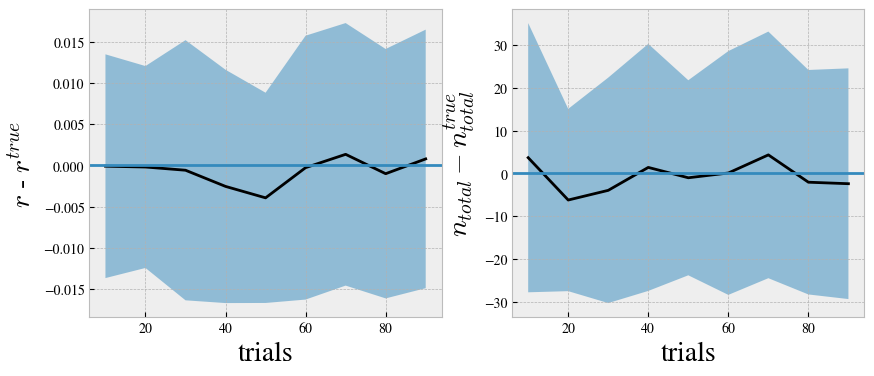

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(ax[0])
plt.fill_between(ntrials, b_r + var_r, b_r - var_r, alpha=0.5)
plt.plot(ntrials, b_r, "-k")
plt.xlabel("trials")
plt.ylabel(r"$r$ - $r^{true}$")
plt.axhline(y = 0)
plt.sca(ax[1])
plt.fill_between(ntrials, b_n + var_n, b_n - var_n, alpha=0.5)
plt.plot(ntrials, b_n, "-k")
plt.axhline(y = 0)
plt.xlabel(r"trials")
plt.ylabel(r"$n_{total} - n^{true}_{total}$")
#plt.ylim(0, 1)
#plt.ylim(0, 0.002)
#plt.semilogx();


#### Comparaison of the different estimators of $r$

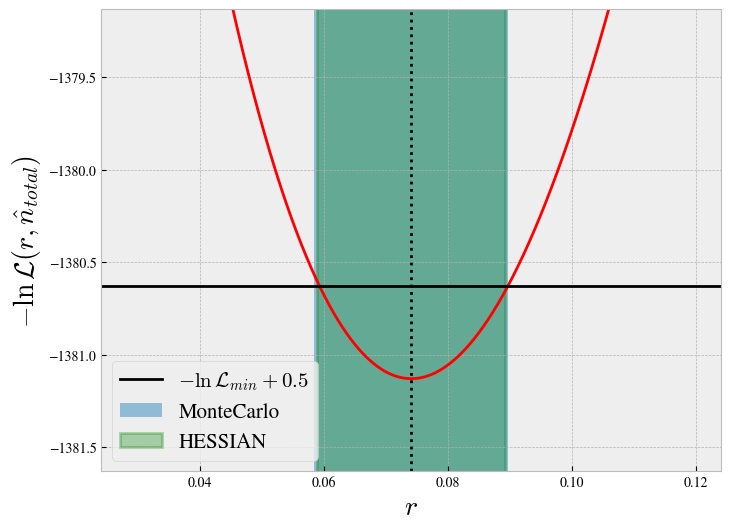

In [47]:
#Let's grab the latests ones
bias = b_r[-1]
std = var_r[-1]

rinf = fit.r - 0.05
rsup = fit.r + 0.05
fig, ax5 = plt.subplots()
x_grid = np.linspace(rinf,rsup,1000)
y =  [UnbinnedNLL(data, signal_generator.pdf, expo_generator.pdf, (fit.ntotal, x)) for x in x_grid]
plt.plot(x_grid, y , 'r')

#horizontal line 0.5 unit higher than min(-ln(L))
level = m.fval + 0.5
ax5.axhline(y = level, lw=2, color = "black", label = r"$-\ln\mathcal{L}_{min} + 0.5$")
ax5.set_xlim(rinf, rsup)
ax5.set_xlabel("$r$")
ax5.set_ylabel(r"$-\ln\mathcal{L}(r, \hat{n}_{total})$")
ax5.set_ylim(m.fval - 0.5, m.fval  + 2)
ax5.axvline(x = fit.r, linestyle="dotted", color="black")
ax5.fill_betweenx(y = np.linspace(m.fval-1, m.fval+10), x1 = fit.r - std, x2 = fit.r + std, alpha=0.5, lw =2, label="MonteCarlo")
ax5.fill_betweenx(y = np.linspace(m.fval-1, m.fval+10), x1 = fit.r - m.errors[1], x2 = fit.r + m.errors[1], alpha = 0.3, color="green", lw = 2, label="HESSIAN")

ax5.legend()
plt.show()




Now consider the following sentences:

In [51]:
print(f'The MC result <r> = {fit.r + bias:.4f} +/- {std:.4f} means that the estimator is unbiased, since the input value of r was {fit.r:.4f}')

The MC result <r> = 0.0741 +/- 0.0152 means that the estimator is unbiased, since the input value of r was 0.0741


In [52]:
print(f'The MC result <r> = {fit.r + bias:.4f} +/- {std:.4f} means that the estimator is unbiased, since the input value of r was {fit.r:.4f} and the R.M.S. of <r> is sigma/sqrt(nexp-1) = {std/np.sqrt(ntrials[-1]-1):.4f}')

The MC result <r> = 0.0741 +/- 0.0152 means that the estimator is unbiased, since the input value of r was 0.0741 and the R.M.S. of <r> is sigma/sqrt(nexp-1) = 0.0016


In [53]:
print(f'The MC result <r> = {fit.r + bias:.4f} +/- {std:.4f} means that the estimator is unbiased when the true value of r is equal to the value  {fit.r:.4f} upon which the pseudo-xps are drawn, since the R.M.S. of <r> is sigma/sqrt(nexp-1) = {std/np.sqrt(ntrials[-1]-1):.4f}. But the unbiasedness property should in principle be checked for any other input value of r.')

The MC result <r> = 0.0741 +/- 0.0152 means that the estimator is unbiased when the true value of r is equal to the value  0.0741 upon which the pseudo-xps are drawn, since the R.M.S. of <r> is sigma/sqrt(nexp-1) = 0.0016. But the unbiasedness property should in principle be checked for any other input value of r.


From what we have learned in the lecture so far, the 3rd sentence is the most correct. But, strictly speaking, the compatibility between two numbers requires a hypothesis test to be defined (e.g. choose a confidence level, choose a test statistic...

### 4. Confidence intervals

#### Likelihood-based confidence intervals on $r$. 

(0.02409843921420765, 0.12409843921420766)

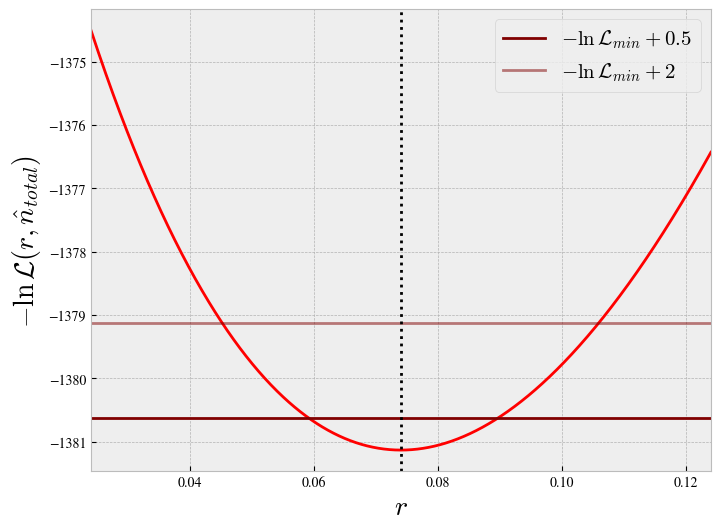

In [43]:
#-ln(L) as a function of r, ntot being fixed to the best-fit value
#choice of the interval in r
rinf = fit.r - 0.05
rsup = fit.r + 0.05

fig, ax5 = plt.subplots()
x_grid = np.linspace(rinf,rsup,1000)
y =  [UnbinnedNLL(data, signal_generator.pdf, expo_generator.pdf, (fit.ntotal, x)) for x in x_grid]
plt.plot(x_grid, y , 'r')

#horizontal line 1 unit higher than min(-ln(L))
level1 = np.min(y) + 0.5
level2 = np.min(y) + 2
ax5.axhline(y = level1, lw=2, color = "maroon", label = r"$-\ln\mathcal{L}_{min} + 0.5$")
ax5.axhline(y = level2, lw=2, color = "maroon", alpha = 0.5, label = r"$-\ln\mathcal{L}_{min} + 2$")
ax5.set_xlabel("$r$")
ax5.axvline(x = fit.r, linestyle="dotted", color="black")
ax5.set_ylabel(r"$-\ln\mathcal{L}(r, \hat{n}_{total})$")
ax5.legend()
ax5.set_xlim(rinf, rsup)


#### Neyman construction 

Using MonteCarlo simulations, one could get the distribution of the best-fit r for many different input values of r, and construct intervals with exact coverage.

See below how the exact construction differs from the interval deduced from the variance of the estimator.

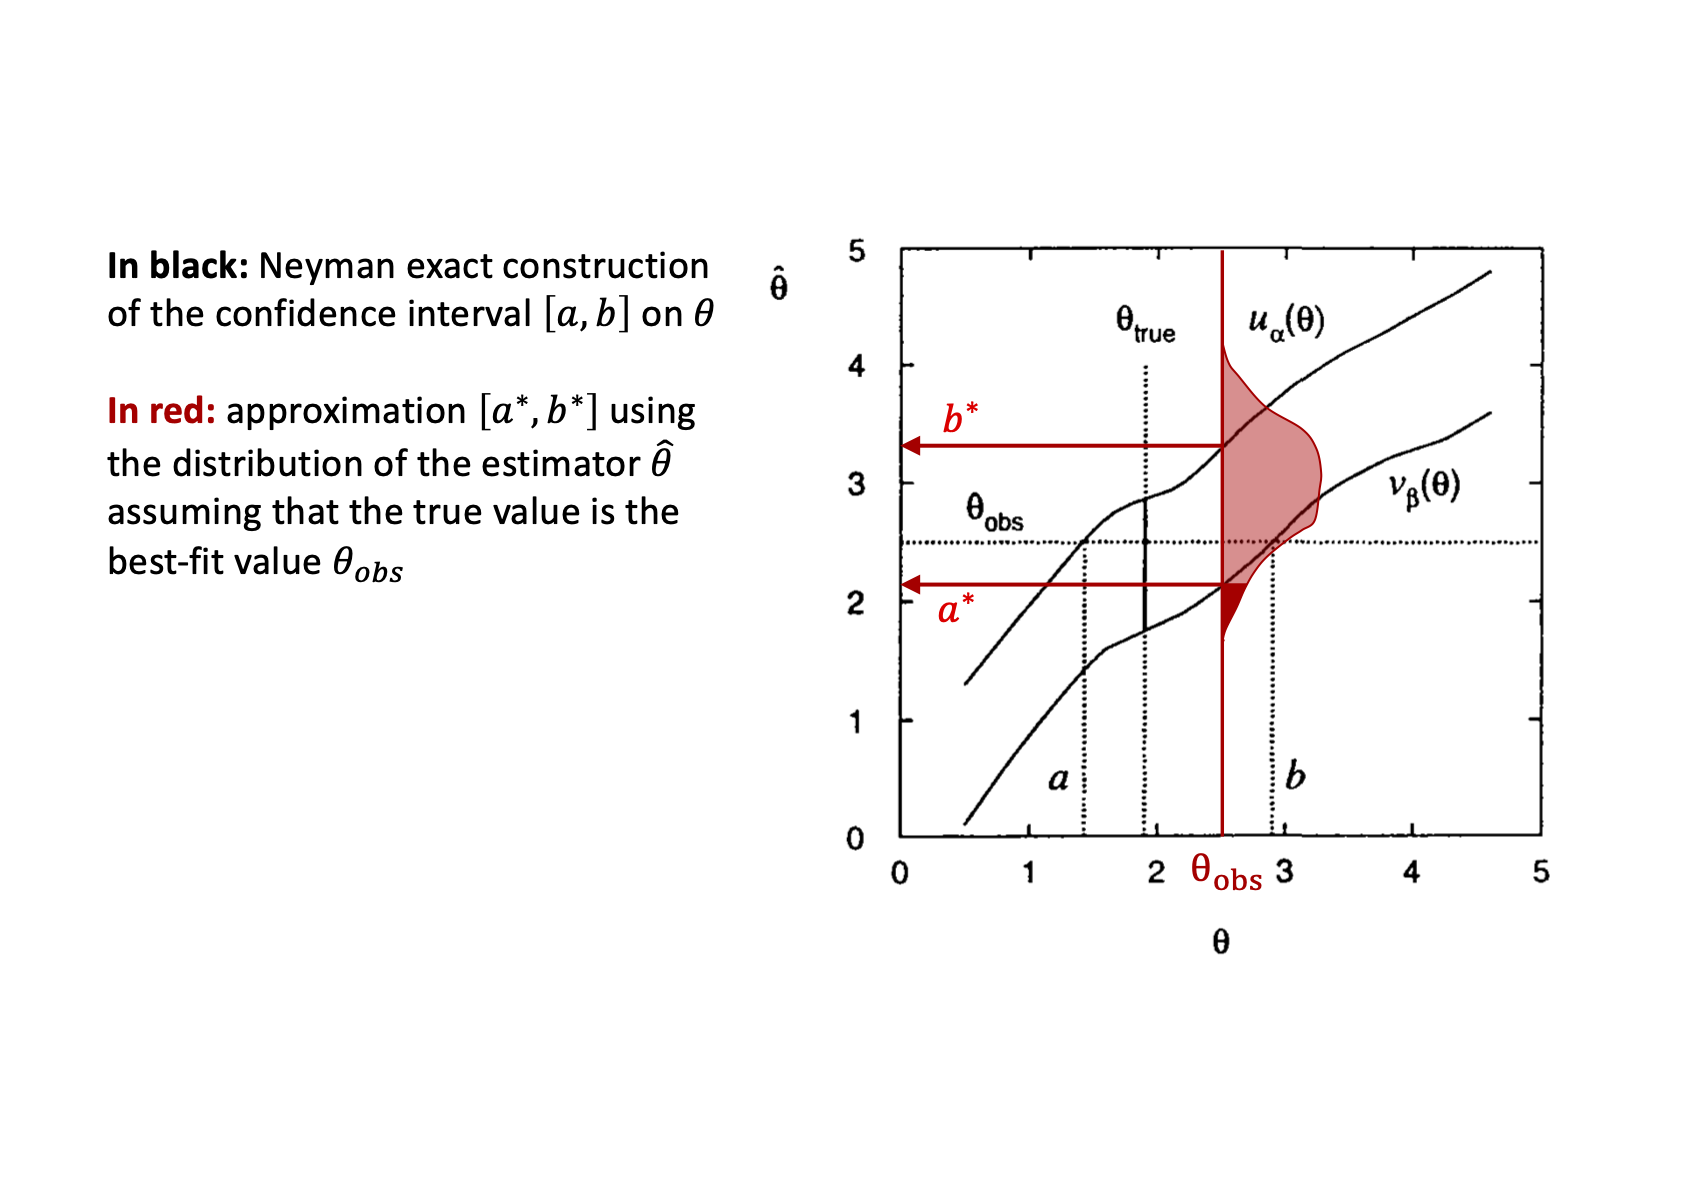

#### Likelihood-based 2D confidence regions on $(n_{total}, r)$.

In [48]:
# Make a grid scan of NLLL values:
nmin = fit.ntotal - 100
nmax = fit.ntotal + 100

rmin = fit.r + 0.08
rmax = fit.r - 0.08
n_grid    = np.linspace(nmin, nmax, 30)
r_grid = np.linspace(rmin, rmax, 30)

L = []
for n in n_grid:
    L_m = []
    for r in r_grid:
        L_m.append(UnbinnedNLL(data, signal_generator.pdf, expo_generator.pdf, (n, r)))
       
    L.append(L_m)
    
# a list of lists => a 2d array
L = np.array(L)

/var/folders/lx/66msvxgn7jbds1ygvq14q5z00000gn/T/ipykernel_74871/552552473.py:7: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = cs.collections[0].get_paths()[0]


Text(0, 0.5, '$n_{total}$')

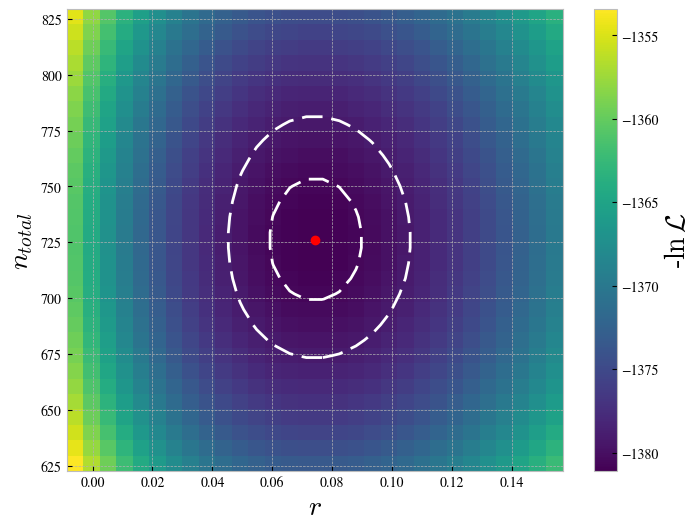

In [49]:
fig1, ax1 = plt.subplots()

mesh = ax1.pcolormesh(r_grid, n_grid, L, shading='auto')

cs = ax1.contour(r_grid, n_grid, L, [L.min() + 0.5, L.min() + 2], colors='white')

p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]

plt.plot(fit.r, fit.ntotal, marker='o',color='r')
cbar = plt.colorbar(mesh)
cbar.ax.set_ylabel(r'-$\ln \mathcal{L}$')

plt.xlabel('$r$')
plt.ylabel('$n_{total}$')


#### Profiling: Reporting a 1D interval on $r$ while treating $n_{total}$ as a nuisance parameter.
In this case we can calculate the likelihood as a function of $r$ but instead of keeping the $n_{total}$ fixed, we minimize also $n_{total}$ for each value of $r$, this is called profiling and corresponds to calculate the likelihood function as $-\ln\mathcal{L}(r, \hat{\hat{n}}_{total})$ where the double hat indicates the estimate $\hat{\hat{n}}_{total}$ is a conditional estimate, in this case for a fixed $r$. A profile likelihood is something that minuit can produce also automatically as we saw before, we can also use `minuit` to fix the parameter $r$ to a given value, and then minimize according to $n_{total}$.

[726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279, 726.0002177247279]


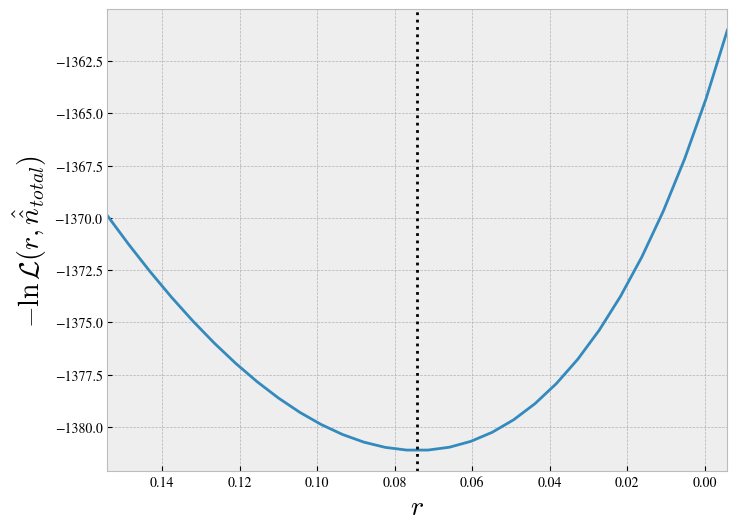

In [51]:
fig1, ax1 = plt.subplots()
L = []
nbest = []
for r in r_grid:
    m.values["$r$"] = r
    m.fixed["$r$"] = True
    m.migrad()
    L.append(m.fval)
    nbest.append(m.values[0])

ax1.plot(r_grid, L)
ax1.set_xlabel(r"$r$")
ax1.set_ylabel(r"$-\ln\mathcal{L}(r, \hat{\hat{n}}_{total})$")
ax1.axvline(x = fit.r, linestyle="dotted", color="black")
ax1.set_xlim(rmin, rmax)
print(nbest)

In the present case, the estimators of $r$ and of $n_{total}$ are not correlated, as can be seen from the direction of the axes of the elliptical confidence region. This makes the profile likelihood curve identical to the 1D curve of $-\ln(\mathcal{L}(r, \hat{n}_{total}))$ with $n_{total}$ being fixed to its best-fit value $\hat{n}_{total}$. 

<h4>Upper limit.</h4>

Your turn now: what are the signal fractions that can be excluded at the 95% confidence level or higher ?